In [1]:
import numpy as np
from scipy.sparse import eye, diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator, interp1d
from scipy.optimize import root_scalar
from scipy.stats import linregress
import matplotlib.pyplot as plt
from numba import njit

# ---------- Model kernels ----------
@njit
def f_numba(N, rho, K):
    # tumour growth: N_t = rho * N * (1 - N/K)
    return rho * N * (1 - N / K)

@njit
def build_laplacian_diagonals_avg(m, D, dx):
    """
    Variable-coefficient diffusion with edge-averaged M:
    (D * M*(1-M) * u_x)_x  with homogeneous Neumann BCs.
    Returns three diagonals (lower, center, upper) scaled by 1/dx^2.
    """
    N = len(m)
    lower = np.zeros(N)
    center = np.zeros(N)
    upper = np.zeros(N)

    for i in range(1, N - 1):
        ml = 0.5 * (m[i - 1] + m[i])
        mr = 0.5 * (m[i] + m[i + 1])
        Dl = max(1e-6, D * ml * (1 - ml))
        Dr = max(1e-6, D * mr * (1 - mr))
        lower[i] = Dl
        upper[i] = Dr
        center[i] = - (Dl + Dr)

    # Neumann BCs at x=0
    mr = 0.5 * (m[0] + m[1])
    Dr = max(1e-6, D * mr * (1 - mr))
    center[0] = -2 * Dr
    upper[0]  =  2 * Dr

    # Neumann BCs at x=L
    ml = 0.5 * (m[-2] + m[-1])
    Dl = max(1e-6, D * ml * (1 - ml))
    center[-1] = -2 * Dl
    lower[-1]  =  2 * Dl

    invdx2 = 1.0 / dx**2
    return invdx2 * lower, invdx2 * center, invdx2 * upper

# ---------- Main class ----------
class Dissertation_Const_1D:
    def __init__(self, D=1.0, rho=1.0, K=1.0, k=1.0,
                 n0=1.0, m0=0.5, Mmax=1.0, perc=0.2,
                 L=1000.0, N=5001, T=1000.0, dt=0.1,
                 scheme="AB2AM2", init_type="step", steepness=0.1,
                 t_start=50.0, t_end=500.0, num_points=200,
                 const=0.0):  # <-- const is the constant source for m_t = const - k*u*m
        # PDE/ODE params
        self.D = D; self.rho = rho; self.K = K       # K here is tumour carrying capacity
        self.k = k; self.const = const               # const is the ECM source (your K in m_t)
        self.n0 = n0; self.m0 = m0
        self.Mmax = Mmax; self.perc = perc
        self.steepness = steepness

        # grid/time
        self.L = L; self.N = N; self.dx = L / (N - 1)
        self.x = np.linspace(0, L, N)
        self.T = T; self.dt = dt; self.Nt = int(T / dt)
        self.scheme = scheme.upper()
        self.init_type = init_type

        # storage
        self.times = np.linspace(0, T, self.Nt)
        self.N_arr = np.zeros((self.Nt, self.N))
        self.M_arr = np.zeros((self.Nt, self.N))
        self.wave_speed = None

        # wave speed tracking params
        self.t_start = t_start
        self.t_end = t_end
        self.num_points = num_points

    # ----- ICs -----
    def initial_condition(self):
        if self.init_type == "step":
            N0 = self.n0 * np.where(self.x < self.perc * self.L, 0.7, 0.0)
        elif self.init_type == "tanh":
            N0 = self.n0 * 0.5 * (1 - np.tanh(self.steepness * (self.x - self.perc * self.L)))
        else:
            raise ValueError("Unknown initial condition type.")
        M0 = self.m0 * self.Mmax * np.ones_like(self.x)
        return N0, M0

    # ----- Diffusion operator -----
    def update_laplacian(self, M):
        lower, center, upper = build_laplacian_diagonals_avg(M, self.D, self.dx)
        return diags([lower[1:], center, upper[:-1]], [-1, 0, 1], format="csr")

    # ----- Time stepping -----
    def solve(self):
        """
        N: AB2–AM2 (IMEX)
        M: implicit Euler for m_t = const - k*u*m with u taken at t^{n+1}:
           M^{n+1} = (M^n + const*dt) / (1 + k*dt*u^{n+1})
        """
        # initial data
        N_prev, M_prev = self.initial_condition()
        f_prev = f_numba(N_prev, self.rho, self.K)
        L_prev = self.update_laplacian(M_prev)

        # first step for N: implicit Euler using M_prev
        A0 = (eye(self.N) - self.dt * L_prev)
        N_curr = spsolve(A0.tocsc(), N_prev + self.dt * f_prev)

        # first step for M: implicit Euler with N_curr
        denom = 1.0 + self.k * self.dt * np.maximum(N_curr, 0.0)
        M_curr = (M_prev + self.const * self.dt) / denom
        np.clip(M_curr, 0.0, self.Mmax, out=M_curr)

        # store first two frames
        self.N_arr[0], self.M_arr[0] = N_prev, M_prev
        self.N_arr[1], self.M_arr[1] = N_curr, M_curr

        # main loop
        for i in range(2, self.Nt):
            # assemble with current M for N's diffusion
            L_curr = self.update_laplacian(M_curr)
            f_curr = f_numba(N_curr, self.rho, self.K)

            # AB2–AM2 for N
            rhs = (eye(self.N) + 0.5 * self.dt * L_prev) @ N_curr + self.dt * (1.5 * f_curr - 0.5 * f_prev)
            A = (eye(self.N) - 0.5 * self.dt * L_curr)
            N_next = spsolve(A.tocsc(), rhs)

            # enforce Neumann ends by copying interior neighbors
            N_next[0], N_next[-1] = N_next[1], N_next[-2]

            # implicit Euler for M with N_next: (M + const*dt)/(1 + k*dt*N_next)
            denom = 1.0 + self.k * self.dt * np.maximum(N_next, 0.0)
            M_next = (M_curr + self.const * self.dt) / denom
            np.clip(M_next, 0.0, self.Mmax, out=M_next)

            # store
            self.N_arr[i] = N_next
            self.M_arr[i] = M_next

            # roll
            N_prev, N_curr = N_curr, N_next
            M_prev, M_curr = M_curr, M_next
            f_prev = f_curr
            L_prev = L_curr

    # ----- Front tracking -----
    def track_wavefront_local_interpolation(self, threshold=0.5, band=(0.1, 0.9),
                                            spline_type='cubic', target='N'):
        x = self.x
        t_vec = self.times
        u_arr = self.N_arr if target.lower() == 'n' else self.M_arr
        t_list = np.linspace(self.t_start, self.t_end, self.num_points)
        x_fronts, t_fronts = [], []

        def get_spline(method, x, y):
            if method == 'cubic': return CubicSpline(x, y)
            if method == 'pchip': return PchipInterpolator(x, y)
            if method == 'akima': return Akima1DInterpolator(x, y)
            if method == 'linear': return interp1d(x, y, kind='linear', fill_value="extrapolate")
            raise ValueError(f"Unsupported spline_type: {method}")

        for t_target in t_list:
            idx = np.argmin(np.abs(t_vec - t_target))
            u = u_arr[idx]
            mask = (u > band[0]) & (u < band[1])
            if np.sum(mask) < 5:
                continue
            x_local, u_local = x[mask], u[mask]
            sort_idx = np.argsort(x_local)
            x_local, u_local = x_local[sort_idx], u_local[sort_idx]
            spline = get_spline(spline_type, x_local, u_local)
            crossing_idx = np.where(np.sign(u_local[:-1] - threshold) != np.sign(u_local[1:] - threshold))[0]
            if len(crossing_idx) == 0:
                continue
            i = crossing_idx[0]
            x_left, x_right = x_local[i], x_local[i + 1]
            try:
                sol = root_scalar(lambda xv: spline(xv) - threshold, bracket=[x_left, x_right])
                if sol.converged:
                    x_star = sol.root
                    x_fronts.append(x_star)
                    t_fronts.append(t_target)
            except Exception:
                continue

        return np.array(t_fronts), np.array(x_fronts)

    def estimate_wave_speed(self, threshold=0.5, band=(0.1, 0.9),
                            spline_type='cubic', plot=True, target='N'):
        t_fronts, x_fronts = self.track_wavefront_local_interpolation(threshold, band, spline_type, target)
        if len(t_fronts) < 2:
            print("❌ Not enough valid front points.")
            return None, None, None

        slope, intercept, r_value, _, _ = linregress(t_fronts, x_fronts)

        if plot:
            plt.figure(figsize=(8, 4))
            plt.plot(t_fronts, x_fronts, 'o', label='Front')
            plt.plot(t_fronts, slope * t_fronts + intercept, 'k--', label=f'Slope = {slope:.3f}')
            plt.xlabel("Time t")
            plt.ylabel("Wavefront x(t)")
            plt.title("Wave Speed via Linear Fit")
            plt.legend(); plt.grid(True); plt.tight_layout()
            plt.show()

        print(f"Estimated speed = {slope:.4f}, R² = {r_value**2:.4f}")
        return slope, intercept, r_value**2

    # ----- Pretty plot for u & m -----
    def plot_u_m_with_custom_style(self, t_indices=[0, 500, 750, 1000],
                                   arrow_len=None, arrow_lw=2.5,
                                   arrow_start_frac=0.5,
                                   head_length=6, head_width=3,
                                   bottom_y=0.2):
        x, N_arr, M_arr, t_vec = self.x, self.N_arr, self.M_arr, self.times

        # Ensure wave speed is available
        if getattr(self, "wave_speed", None) is None:
            self.wave_speed, _, _ = self.estimate_wave_speed(
                plot=False, target='N', threshold=0.5, band=(0.1, 0.9), spline_type='cubic'
            )

        # Arrow geometry
        if arrow_len is None:
            arrow_len = 0.15 * self.L  # default 15% of domain

        arrow_x_start = np.clip(arrow_start_frac * self.L, 0.0, self.L)
        arrow_x_end   = np.clip(arrow_x_start + arrow_len, 0.0, self.L)
        if arrow_x_end <= arrow_x_start:
            arrow_x_start = np.clip(self.L - arrow_len, 0.0, self.L)
            arrow_x_end   = self.L

        plt.figure(figsize=(8, 6))

        # Plot profiles (dashed for t=0)
        for tidx in t_indices:
            t_label = int(t_vec[tidx])
            ls = '--' if t_label == 0 else '-'
            plt.plot(x, N_arr[tidx], color='red',  linestyle=ls, label=rf"$u(x,{t_label})$")
            plt.plot(x, M_arr[tidx], color='blue', linestyle=ls, label=rf"$m(x,{t_label})$")

        # Arrow styles
        arrow_style_red  = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='red',  lw=arrow_lw)
        arrow_style_blue = dict(arrowstyle=f'->,head_length={head_length},head_width={head_width}',
                                color='blue', lw=arrow_lw)

        # Draw arrows
        plt.annotate('', xy=(arrow_x_end, 0.9),      xytext=(arrow_x_start, 0.9),      arrowprops=arrow_style_red)
        plt.annotate('', xy=(arrow_x_end, bottom_y), xytext=(arrow_x_start, bottom_y), arrowprops=arrow_style_blue)

        # Left-side text
        x_text = x[0] + 0.02 * self.L
        c_str = f"{self.wave_speed:.3g}" if self.wave_speed is not None else "—"
        plt.text(x_text, 0.92, rf"$\overline{{m}} = {self.m0}$", fontsize=18, ha='left')
        plt.text(x_text, 0.82, rf"$c = {c_str}$", fontsize=18, ha='left')

        # Formatting
        plt.xlabel(r"$x$", fontsize=18)
        plt.ylabel(r"$u(x,t),\, m(x,t)$", fontsize=18)
        plt.ylim([-0.05, 1.05])
        plt.yticks([0.0, 0.5, 1.0], fontsize=16)
        plt.xticks(fontsize=16)
        plt.title(rf"$\lambda = {self.k}$", fontsize=20)
        plt.xlim([0, self.L])
        plt.grid(False)
        plt.tight_layout()
        plt.show()

<h2> Incr Lambda and have Const = 0.001

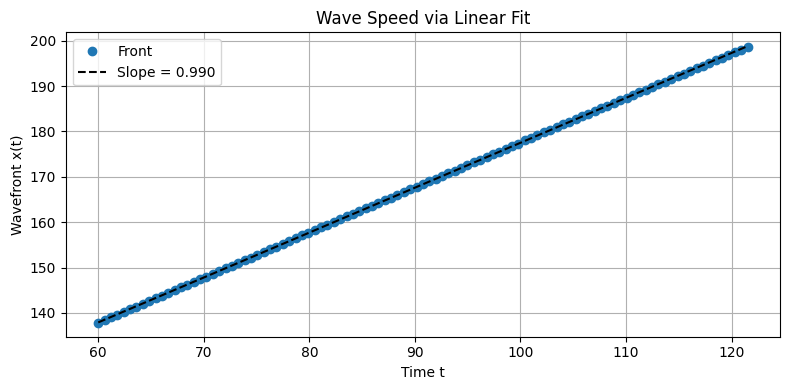

Estimated speed = 0.9895, R² = 1.0000
Estimated speed = 0.9895, R² = 1.0000


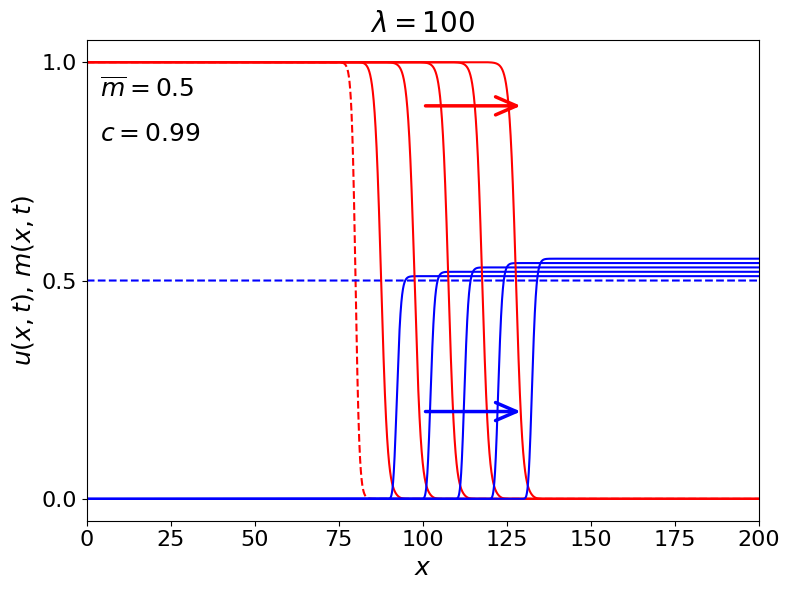

In [5]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 100, const = 0.001,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=60, t_end=180, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

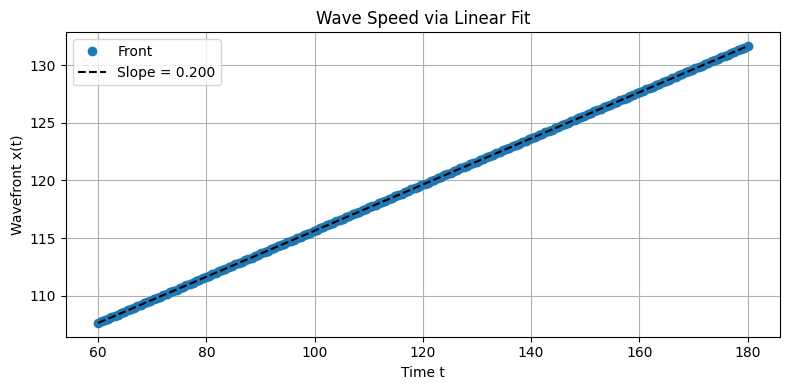

Estimated speed = 0.1999, R² = 1.0000
Estimated speed = 0.1999, R² = 1.0000


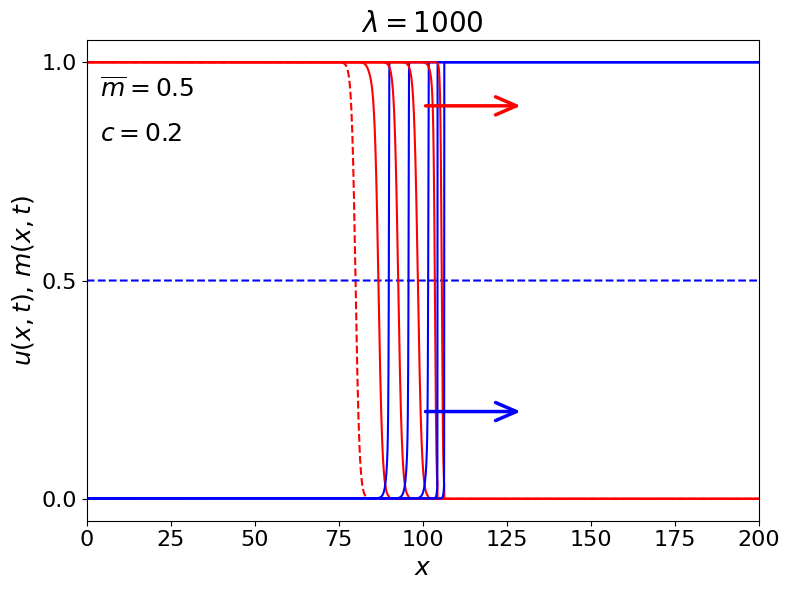

In [7]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 1000, const = 1,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=60, t_end=180, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

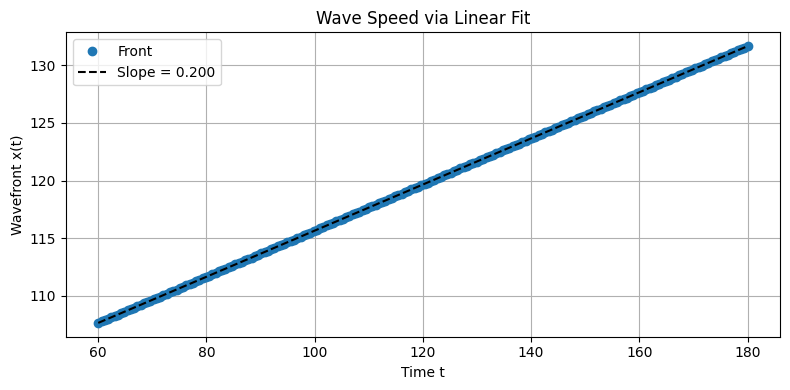

Estimated speed = 0.1999, R² = 1.0000
Estimated speed = 0.1999, R² = 1.0000


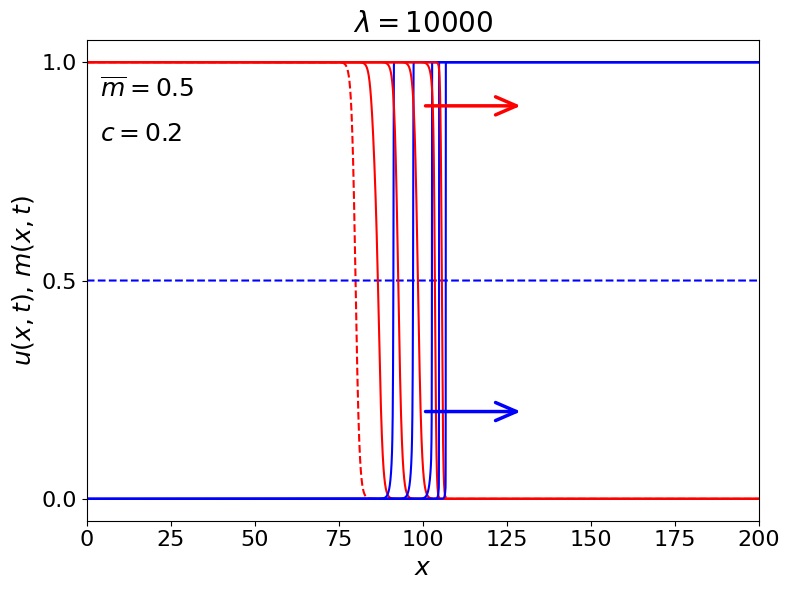

In [8]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 10000, const = 1,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=60, t_end=180, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

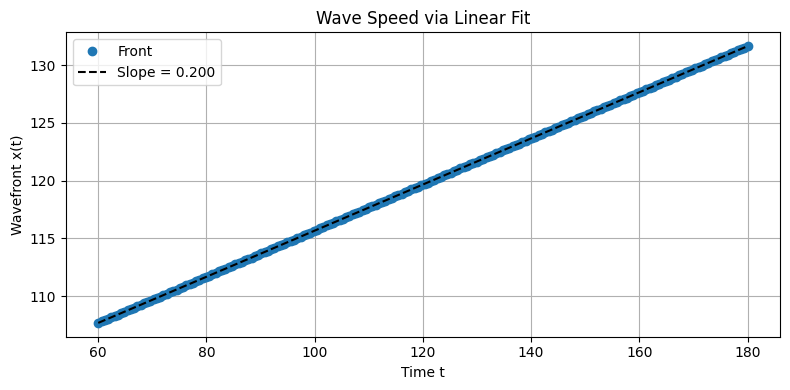

Estimated speed = 0.1999, R² = 1.0000
Estimated speed = 0.1999, R² = 1.0000


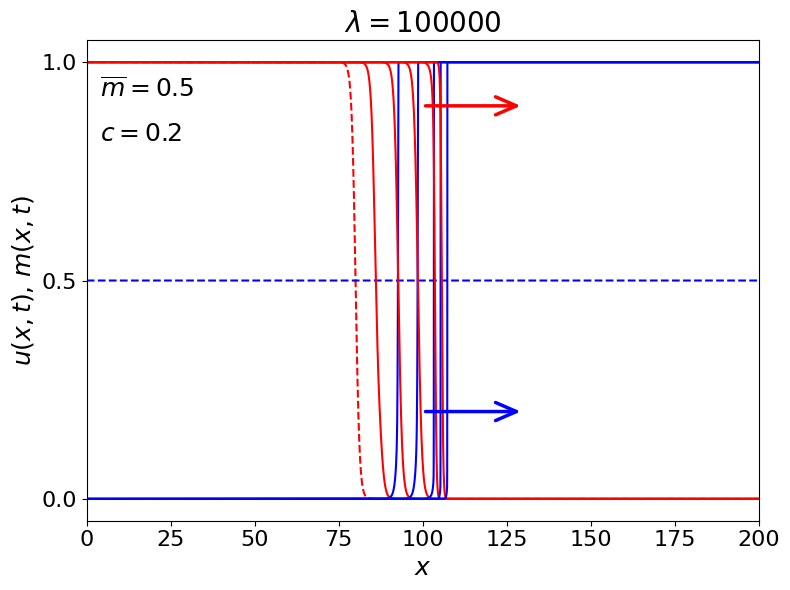

In [9]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 100000, const = 1,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=60, t_end=180, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

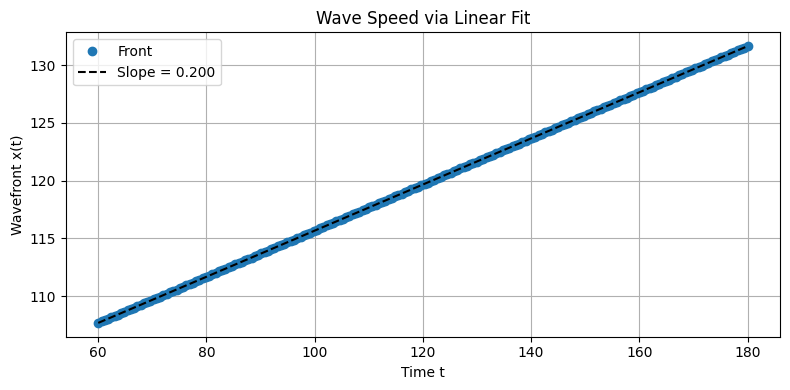

Estimated speed = 0.1999, R² = 1.0000
Estimated speed = 0.1999, R² = 1.0000


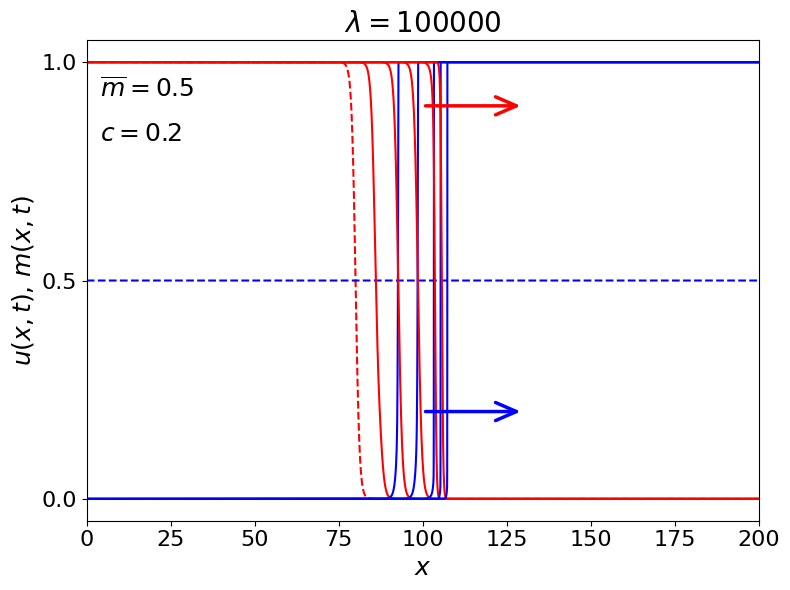

In [10]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 100000, const = 1,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=60, t_end=180, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

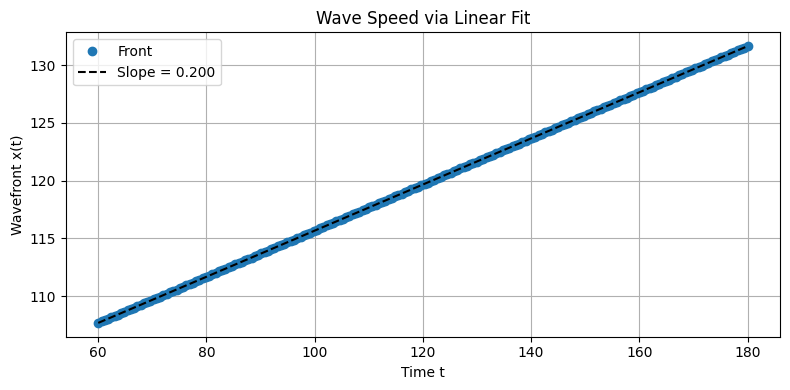

Estimated speed = 0.1999, R² = 1.0000
Estimated speed = 0.1999, R² = 1.0000


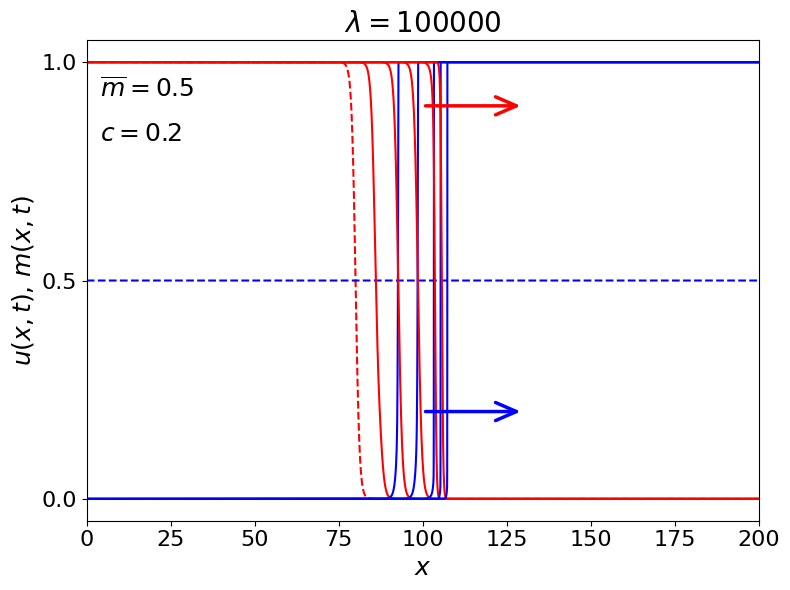

In [11]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 100000, const = 1,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=60, t_end=180, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

<h2> Incr Lambda and have Const = 0.01

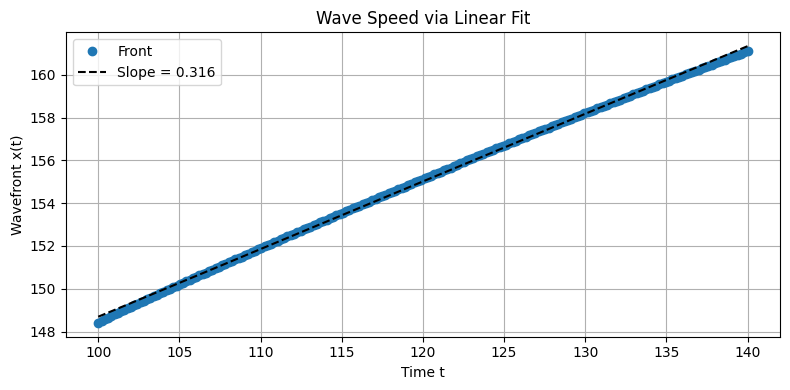

Estimated speed = 0.3160, R² = 0.9991
Estimated speed = 0.3160, R² = 0.9991


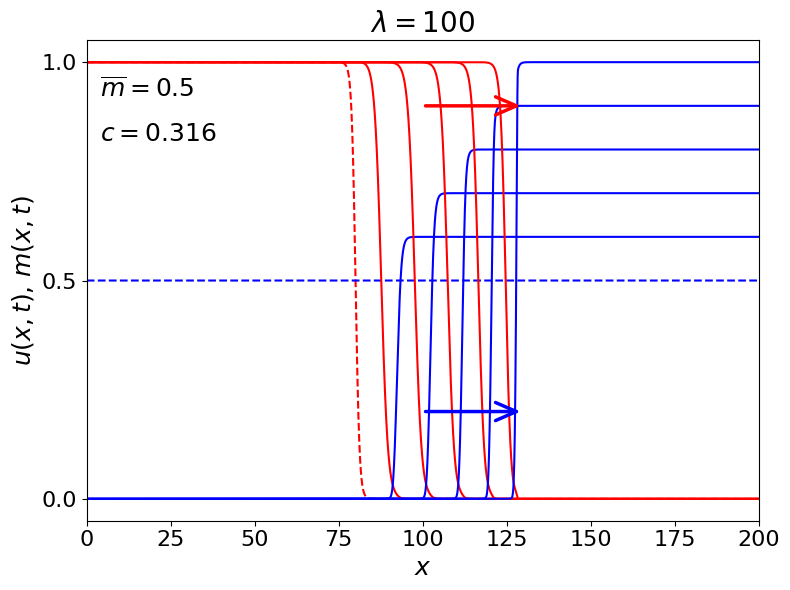

In [6]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 100, const = 0.01,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

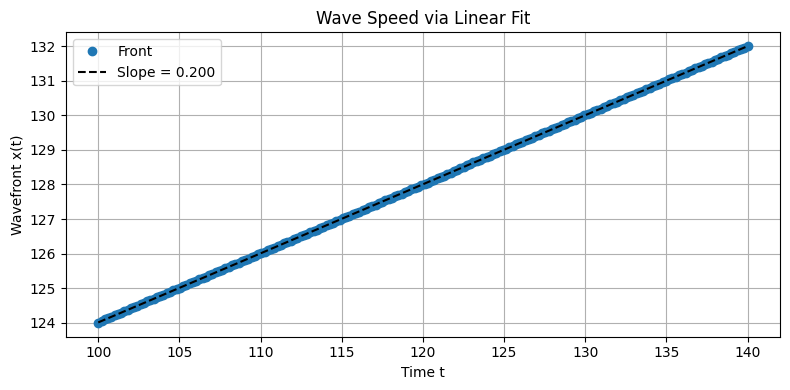

Estimated speed = 0.1998, R² = 1.0000
Estimated speed = 0.1998, R² = 1.0000


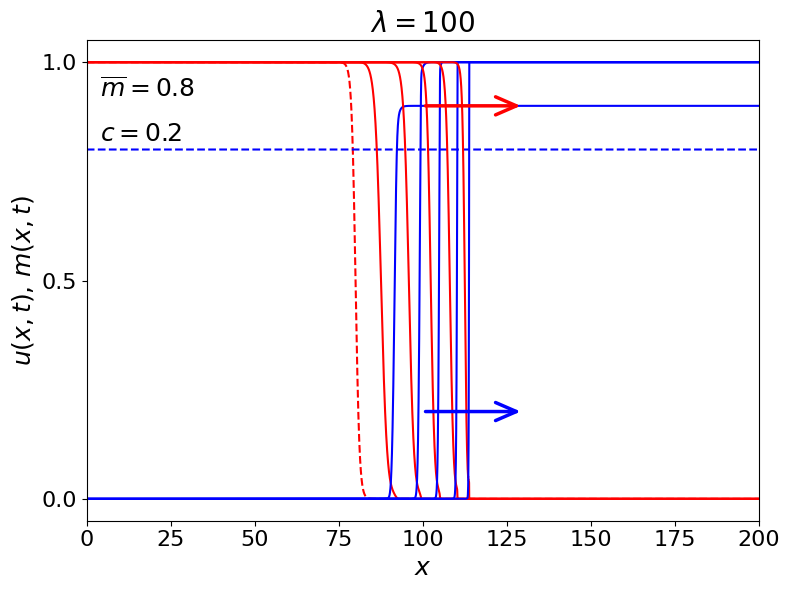

In [7]:
model_08_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 100, const = 0.01, m0 =0.8,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_08_01.solve() 
model_08_01.estimate_wave_speed(plot=True)
model_08_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

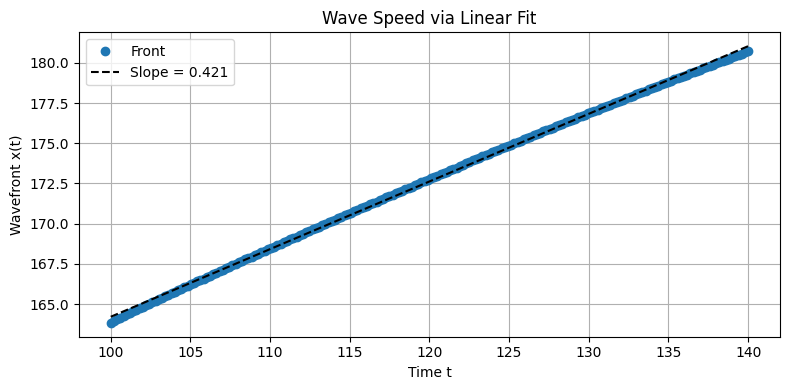

Estimated speed = 0.4208, R² = 0.9991
Estimated speed = 0.4208, R² = 0.9991


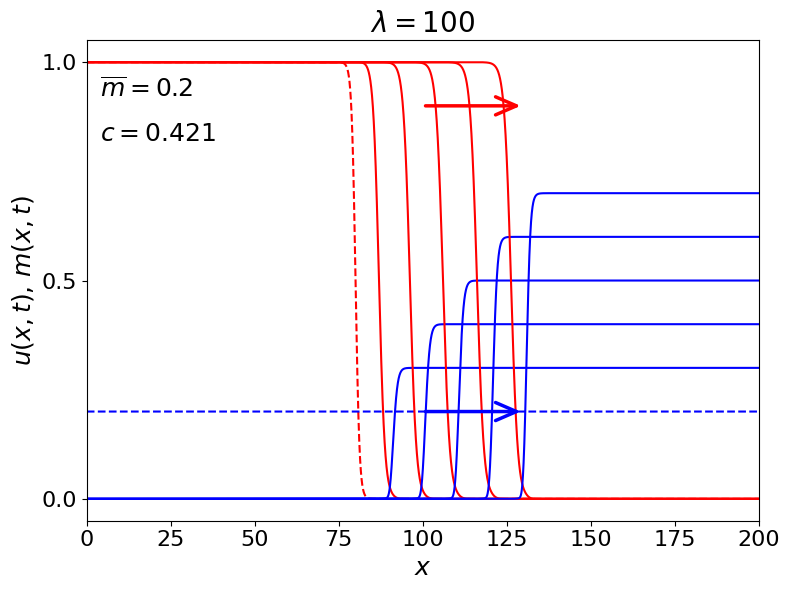

In [8]:
model_02_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 100, const = 0.01, m0 =0.2,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_02_01.solve() 
model_02_01.estimate_wave_speed(plot=True)
model_02_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

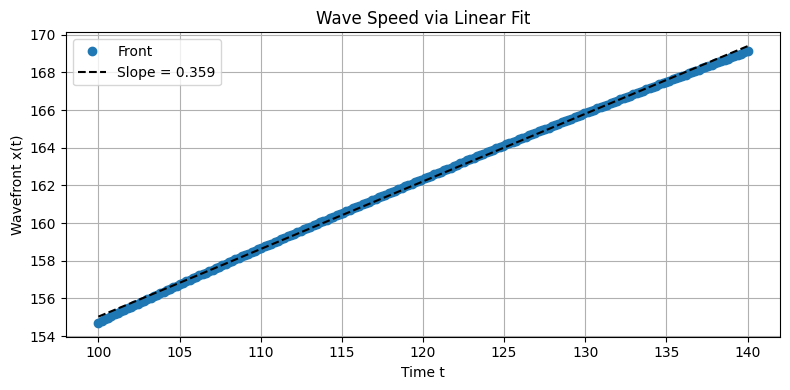

Estimated speed = 0.3590, R² = 0.9991
Estimated speed = 0.3590, R² = 0.9991


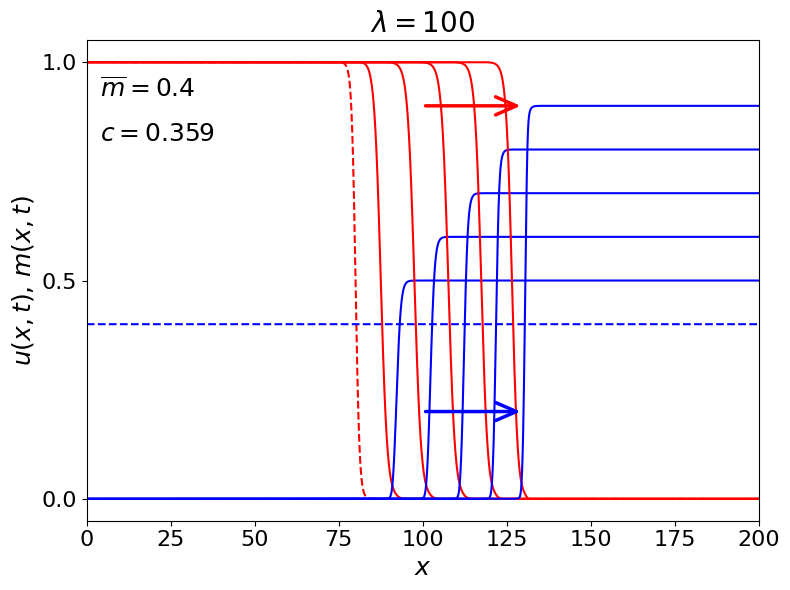

In [9]:
model_04_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 100, const = 0.01, m0 =0.4,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_04_01.solve() 
model_04_01.estimate_wave_speed(plot=True)
model_04_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

<h3> lam = 1000

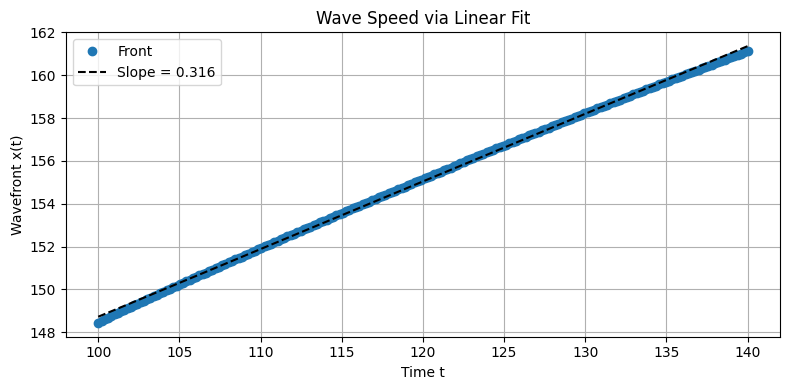

Estimated speed = 0.3159, R² = 0.9991
Estimated speed = 0.3159, R² = 0.9991


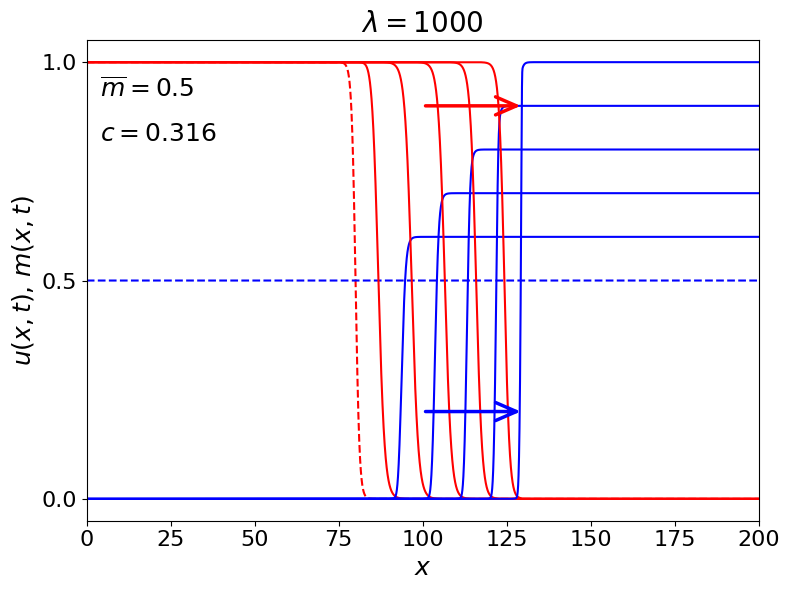

In [11]:
model_05_1000 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 1000, const = 0.01,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_05_1000.solve() 
model_05_1000.estimate_wave_speed(plot=True)
model_05_1000.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

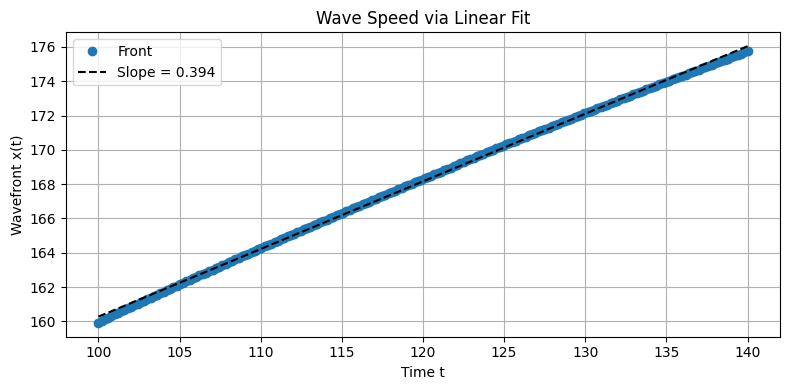

Estimated speed = 0.3940, R² = 0.9991
Estimated speed = 0.3940, R² = 0.9991


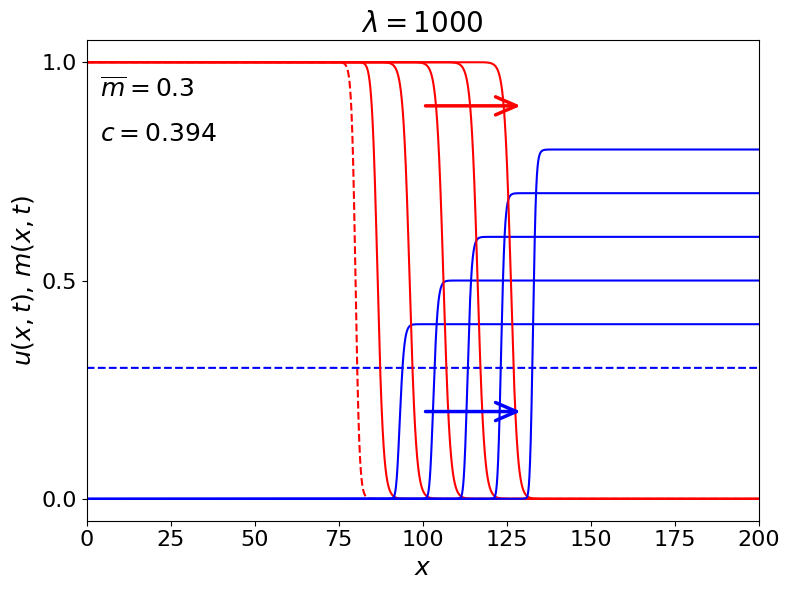

In [12]:
model_03_1000 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 1000, const = 0.01, m0=0.3,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_03_1000.solve() 
model_03_1000.estimate_wave_speed(plot=True)
model_03_1000.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

<h3> lam = 10^4

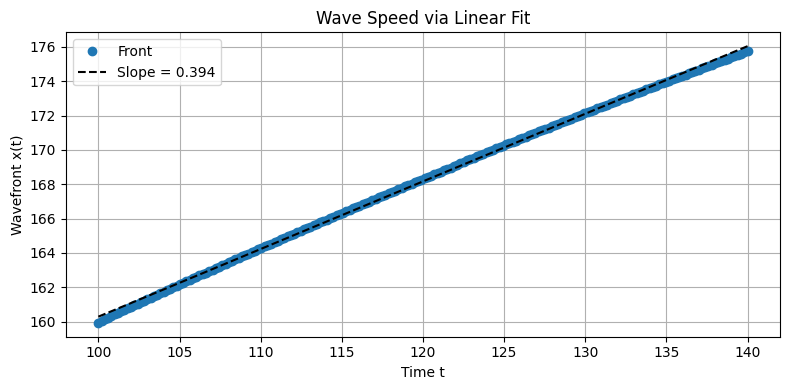

Estimated speed = 0.3940, R² = 0.9991
Estimated speed = 0.3940, R² = 0.9991


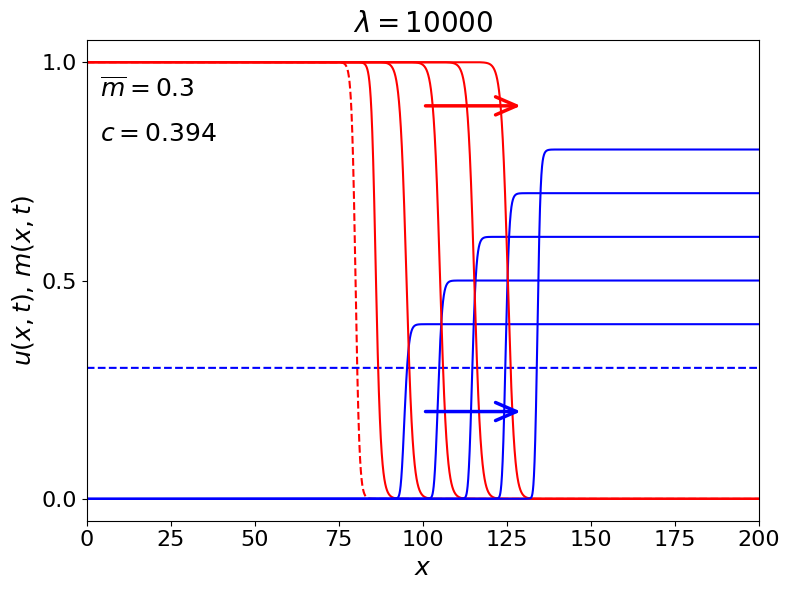

In [13]:
model_03_10000 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 10000, const = 0.01, m0=0.3,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_03_10000.solve() 
model_03_10000.estimate_wave_speed(plot=True)
model_03_10000.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

<h2> const = 1

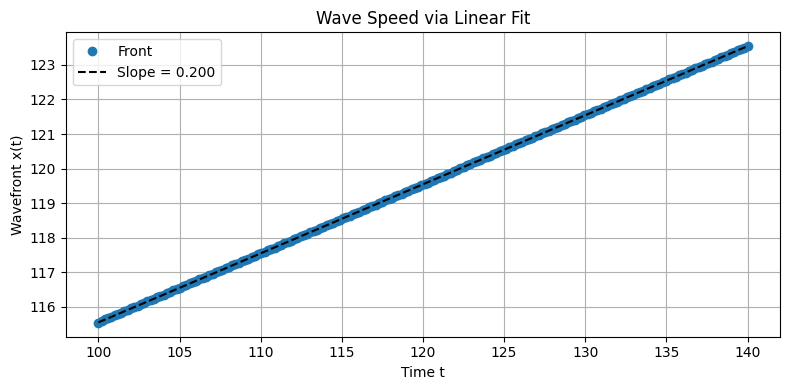

Estimated speed = 0.1998, R² = 1.0000
Estimated speed = 0.1998, R² = 1.0000


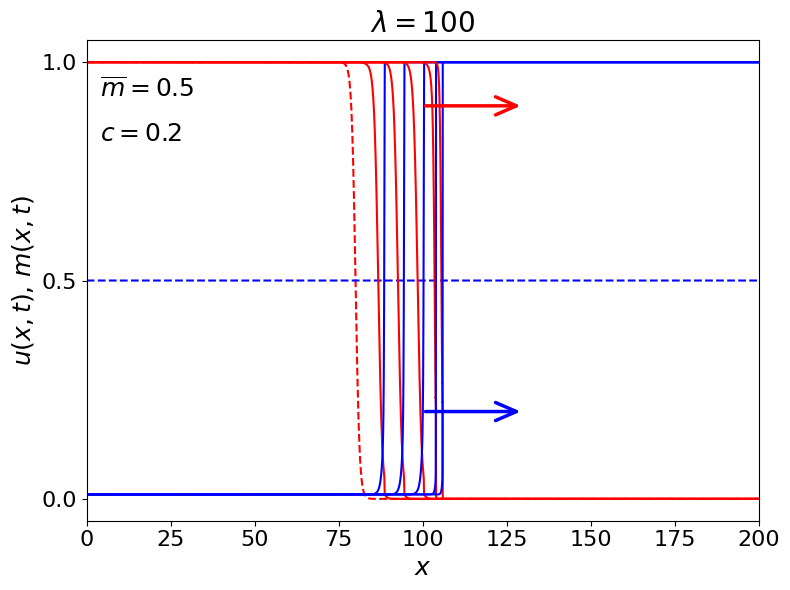

In [15]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 100, const = 1,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

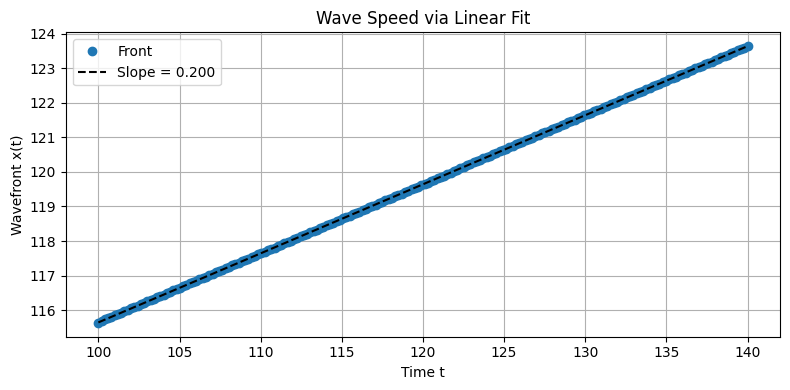

Estimated speed = 0.1998, R² = 1.0000
Estimated speed = 0.1998, R² = 1.0000


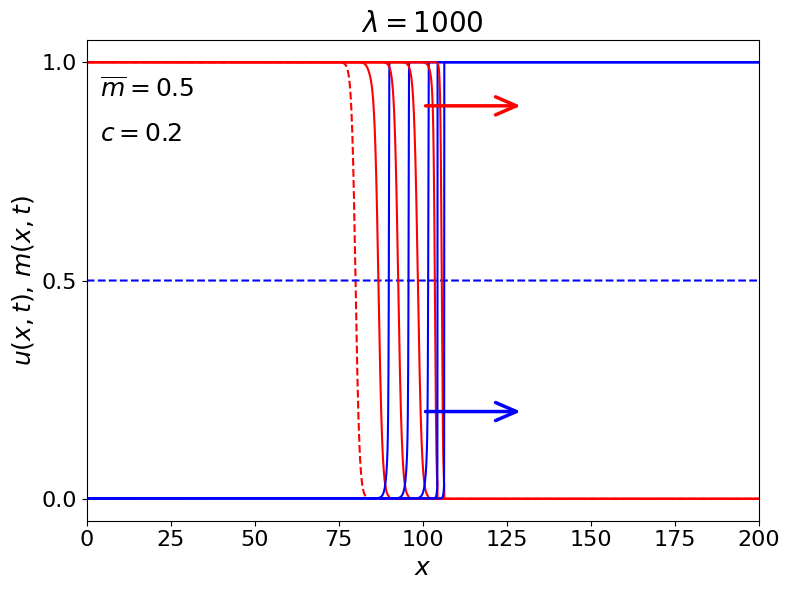

In [16]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=10001, T=200, dt=0.1, k = 1000, const = 1,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

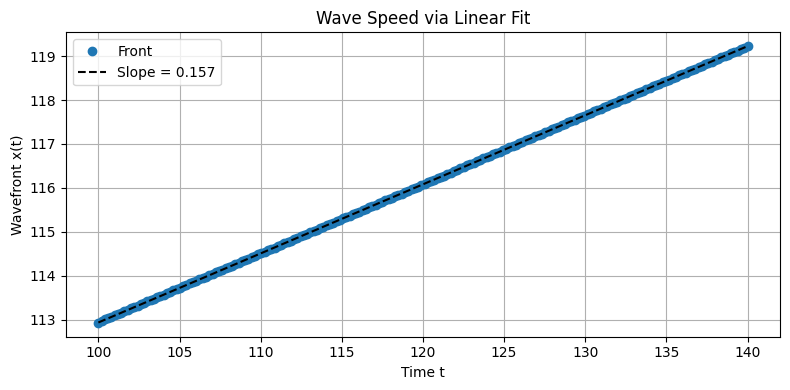

Estimated speed = 0.1573, R² = 1.0000
Estimated speed = 0.1573, R² = 1.0000


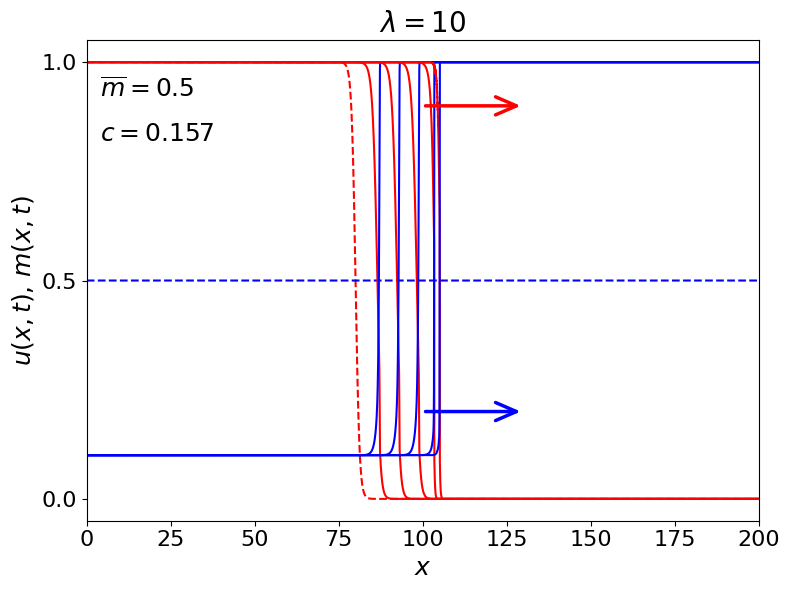

In [18]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=20001, T=200, dt=0.1, k = 10, const = 1,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

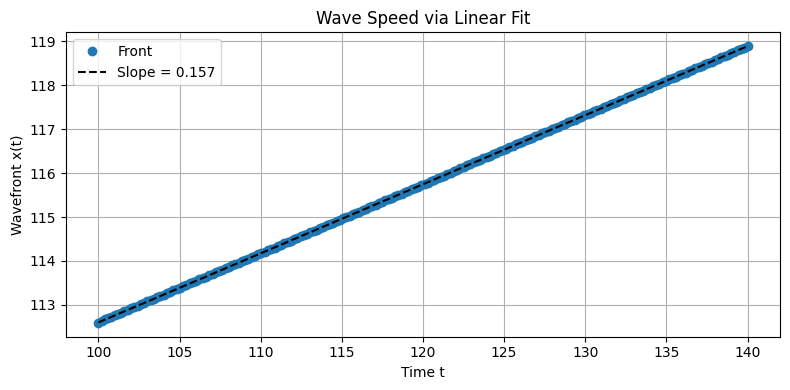

Estimated speed = 0.1573, R² = 1.0000
Estimated speed = 0.1573, R² = 1.0000


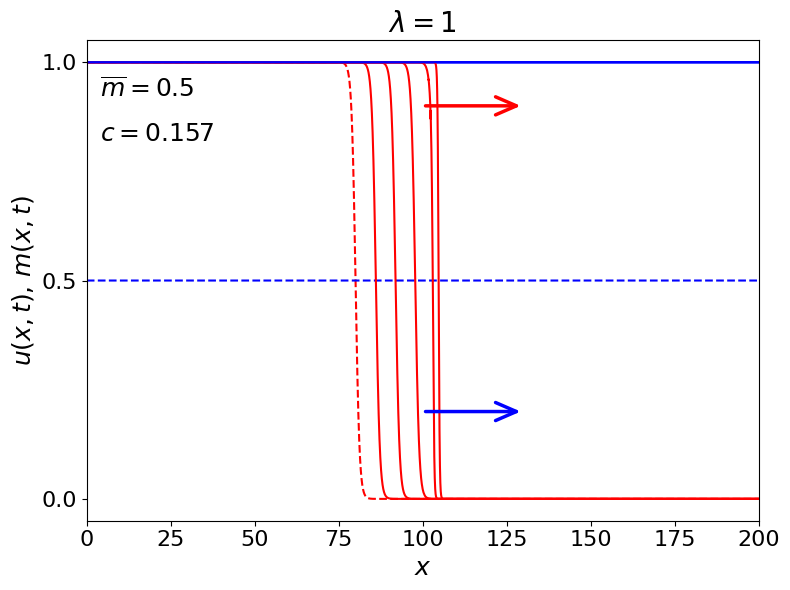

In [19]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=20001, T=200, dt=0.1, k = 1, const = 1,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)

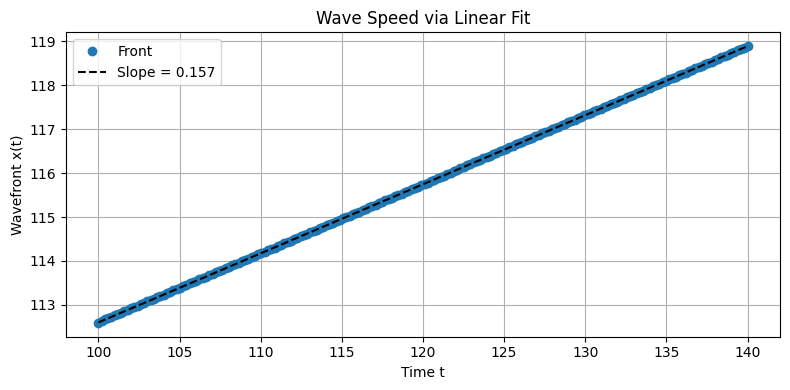

Estimated speed = 0.1573, R² = 1.0000
Estimated speed = 0.1573, R² = 1.0000


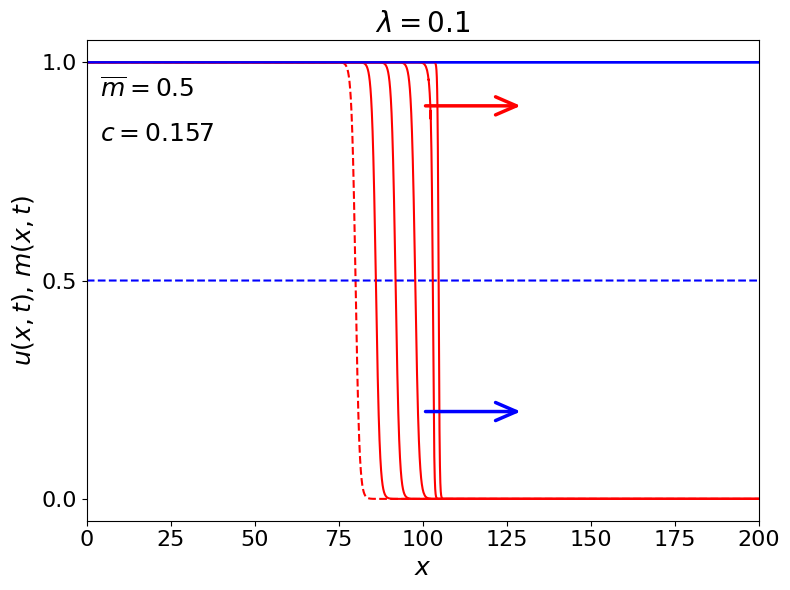

In [20]:
model_05_01 = Dissertation_Const_1D(
    L=200, N=20001, T=200, dt=0.1, k = 0.1, const = 1,
    init_type="tanh", steepness=.85, perc=0.4,
    t_start=100, t_end=140, num_points=200
)
model_05_01.solve() 
model_05_01.estimate_wave_speed(plot=True)
model_05_01.plot_u_m_with_custom_style([0, 100,200, 300, 400, 500], head_length=1.5, head_width=.65)